## Modelowanie ryzyka kredytowego i operacyjnego - Zadanie 1

### Część teoretyczna:
Ryzyko kredytowe to ryzyko (nieznany wynik przedsięwzięcia) wynikające z możliwości niedotrzymania warunków umowy kredytowej przez jedną ze stron (np. niespłacenie kredytu przez kredytobiorcę) lub zmianę wiarygodności kredytowej.

Analiza dyskryminacyjna jest metodą podziału obiektów na grupy pod względem zmiennej objaśnianej. Pozwala ona wybrać najlepsze zmienne objaśniające przydział obiektów do konkretnej grupy. Może być przeprowadzona np. poprzez przedstawienie obiektów podzielonych na grupy względem realnej wartości zmiennej objaśnianej w przestrzeni a następnie takie dobieranie zmiennych objaśniających, aby rozkłady grup były jak najbardziej różne. Taka analiza może być przeprowadzona poprzez analizowanie wszystkich niewybranych zmiennych i wybieranie najlepszych lub wybór i analizę wszystkich zmiennych, spośród których odrzucamy kolejne najgorsze.\
Jest ona przydatna w analizie ryzyka kredytowego ponieważ dzięki niej można na podstawie pewnego zbioru uczącego dostarczającego informacje np. o upadłości firm wyznaczyć model, który na podstawie wybranych zmiennych i informacji o upadłości pozwala przewidywać czy firma jest zagrożona upadłością czy nie. 

Model Altmana to model służący do prognozowania upadłości firm.\
Ma on postać $Z = 1.2 X_1 + 1.4 X_2 +3.3 X_3 + 0.6 X_4 + 0.99 X_5$, gdzie
- $X_1 = \frac{\text{aktywa obrotowe}}{\text{aktywa ogółem}}$

- $X_2 = \frac{\text{zysk zatrzymany}}{\text{aktywa ogółem}}$
- $X_3 = \frac{\text{zysk przed spłatą odsetek i podatkiem}}{\text{aktywa ogółem}}$
- $X_4 = \frac{\text{wartość rynkowa kapitału akcyjnego}}{\text{wartość księgowa zadłużenia}}$
- $X_5 = \frac{\text{przychody ze sprzedaży}}{\text{aktywa ogółem}}$

W zależności od wyników Z przyjmuje się różne prawdopodobieństwo bankructwa (bankructwo mało prawdopodobne, bardzo prawdopodobne, szara strefa).\
Ma on pewne ograniczenia: model jest liniowy i bardzo prosty, co mogło lepiej sprawdzać się w latach jego powstawania, jednak obecnie działania firm bardzo się różnią, przede wszystkim wiele firm działa globalnie i zmaga się z innymi zagrożeniami. Ponadto został zbudowany na danych z firm działających w Ameryce w latach 50-70, zatem raczej nie będzie on aż tak dokładny w obecnych czasach. Ponadto model bazuje na danych księgowych, które udostępniane są zwykle raz w roku lub kwartalnie, w zależności od organizacji.


In [127]:
import pandas as pd
import numpy as np
import warnings
import scipy.io.arff as arff
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [128]:
#wczytanie całości danych
whole_data = pd.DataFrame(arff.loadarff('1year.arff')[0])
#zamiana klasy na 0 i 1
whole_data = whole_data.replace(b'1', "1")
whole_data = whole_data.replace(b'0', "0")
#podział danych na bankrutów i niebankrutów
bankrupt = whole_data[whole_data['class'] == "1"]
non_bankrupt = whole_data[whole_data['class'] == "0"]
#wybranie po 100 firm z obu grup
random_b = bankrupt.sample(n=100)
random_nb = non_bankrupt.sample(n=100)

Poprawność klasyfikacji ogółem: 62.50%
Poprawność klasyfikacji bankrutów: 64.00%
Poprawność klasyfikacji niebankrutów: 61.00%


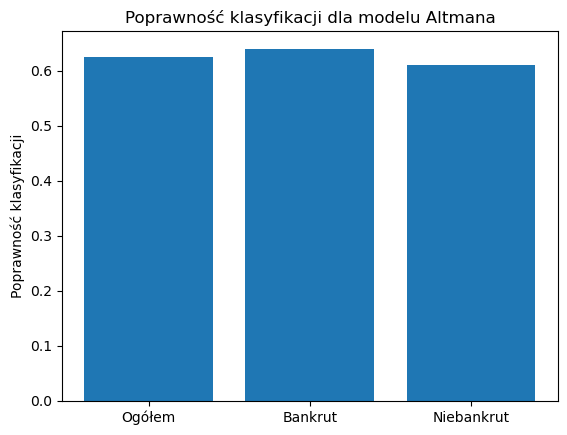

In [129]:
#wybór zmiennych ze zbioru, zgodnych ze zmiennymi w modelu Altmana
vars =  ['Attr3', 'Attr6', 'Attr7', 'Attr8', 'Attr9','class']
vars_attr = vars[:-1]
#połączenie próbek danych i pozbycie się brakujących wartości
data = pd.concat([random_b[vars], random_nb[vars]])
data.dropna(inplace=True)

#wyznaczenie Z Altmana i predykcji na jej podstawie
data["Z"] = 1.2*data[vars[0]] + 1.4*data[vars[1]] + 3.3*data[vars[2]] + 0.6*data[vars[3]] + 0.99*data[vars[4]]
data["class_prediction"] = np.where(data["Z"] < 2.67, "1", "0")

#obliczenie procentowej poprawności klasyfikacji
count_b = len(data[(data['class'] == "1") & (data['class_prediction'] == '1')])
count_nb = len(data[(data['class'] == "0") & (data['class_prediction'] == '0')])
count_all = len(data[((data['class'] == "1") & (data['class_prediction'] == '1')) | ((data['class'] == "0") & (data['class_prediction'] == '0'))])
print("Poprawność klasyfikacji ogółem: {:.2%}".format(count_all/len(data)))
print("Poprawność klasyfikacji bankrutów: {:.2%}".format(count_b/len(data[data['class'] == "1"])))
print("Poprawność klasyfikacji niebankrutów: {:.2%}".format(count_nb/len(data[data['class'] == "0"])))
#przedstawienie wykresów poprawności klasyfikacji
fig, ax = plt.subplots()
ax.bar(["Ogółem", "Bankrut", "Niebankrut"], [count_all/len(data), count_b/len(data[data['class'] == "1"]), count_nb/len(data[data['class'] == "0"])])
ax.set_ylabel('Poprawność klasyfikacji')
ax.set_title('Poprawność klasyfikacji dla modelu Altmana')
plt.show()

Oryginalny model nie jest zbyt skutecznym narzędziem jeśli chodzi o predykcję upadłości. Jest to spowodowane prawdopodobnie tym, że model został zbudowany na podstawie amerykańskich firm z lat 50-70. Obecnie firmy podlegają innym zagrożeniom i szansom, działają również w trochę inny sposób. Różnica w skuteczności może wynikać właśnie z tych różnic między firmami sprzed lat a obecnymi.

In [130]:
#przeprowadzenie LDA na podstawie zmiennych zgodnych z modelem Altmana i wyznaczenie nowego modelu 
X = data.drop(['class', 'Z', 'class_prediction'], axis=1)
Y = pd.DataFrame(data['class'])
lda = LinearDiscriminantAnalysis()
lda.fit(X, Y)
data['lda_z'] = lda.transform(data[vars_attr])
data['lda_predicted_class'] = lda.predict(data[vars_attr])
coef = np.round(lda.coef_, 2)
intercept = np.round(lda.intercept_, 2)

Poprawność klasyfikacji ogółem = 70.00%
Poprawność klasyfikacji bankrutów = 71.00%
Poprawność klasyfikacji niebankrutów = 69.00%
Wzór funkcji dyskryminacyjnej: -0.81 * X1 + -0.77 * X2 + -3.2 * X3 + -0.01 * X4 + 0.16 * X5 + 0.11


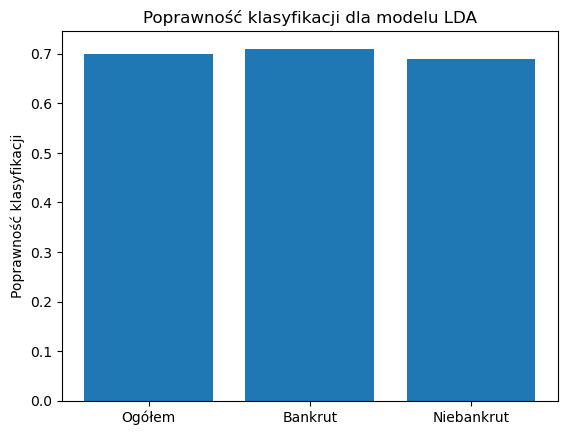

In [131]:
#obliczenie poprawności klasyfikacji i przedstawienie wzoru nowego modelu
print('Poprawność klasyfikacji ogółem = {:.2%}'.format(np.sum((data['class'] == data['lda_predicted_class'])) / len(data)))
print('Poprawność klasyfikacji bankrutów = {:.2%}'.format(np.sum((data['class'] == data['lda_predicted_class']) & (data['class'] == "1")) / len(data[data['class'] == "1"])))
print('Poprawność klasyfikacji niebankrutów = {:.2%}'.format(np.sum((data['class'] == data['lda_predicted_class']) & (data['class'] == "0")) / len(data[data['class'] == "0"])))
print('Wzór funkcji dyskryminacyjnej:',coef[0][0], '* X1 +', coef[0][1], '* X2 +', coef[0][2], '* X3 +', coef[0][3], '* X4 +', coef[0][4], '* X5 +', intercept[0])

#przedstawienie wykresu poprawności klasyfikacji
fig, ax = plt.subplots()
ax.bar(["Ogółem", "Bankrut", "Niebankrut"], [np.sum((data['class'] == data['lda_predicted_class'])) / len(data), np.sum((data['class'] == data['lda_predicted_class']) & (data['class'] == "1")) / len(data[data['class'] == "1"]), np.sum((data['class'] == data['lda_predicted_class']) & (data['class'] == "0")) / len(data[data['class'] == "0"])])
ax.set_ylabel('Poprawność klasyfikacji')
ax.set_title('Poprawność klasyfikacji dla modelu LDA')
plt.show()

Nowy model zbudowany dla współczesnych, polskich firm, znacząco różni się od pierwotnego modelu Altmana. Różnice te oznaczają wpływ danych zmiennych na określenie wartości Z, która wpływa na określenie bankructwa. Nowy model wyznaczony z pomocą LDA określa inny wpływ kolejnych zmiennych, uwzględnia również pewną stałą.\
Nowy model jest też bardziej skuteczny od pierwotnego, aczkolwiek nie jest to wielka różnica. Zmienia się ona również przy poszczególnych próbach obliczenia nowego modelu, ponieważ korzystamy z LDA, która za każdym razem może być przeprowadzona przez algorytm w trochę inny sposób, dając inne wyniki.

### W dalszej części wykorzystam modele Springate'a oraz B. Prusaka:
#### Model Springate'a
- $X_1 = \frac{\text{kapitał pracujący}}{\text{aktywa ogółem}}$ - $X_3$ w naszym zbiorze danych

- $X_2 = \frac{\text{zysk przed spłatą odsetek i podatkiem}}{\text{aktywa ogółem}}$ - $X_7$ w naszym zbiorze danych
- $X_3 = \frac{\text{wynik brutto}}{\text{zobowiązania krótkoreminowe}}$ - $X_{12}$ w naszym zbiorze danych
- $X_4 = \frac{\text{przychody ze sprzedaży}}{\text{aktywa ogółem}}$ - $X_1$ w naszym zbiorze danych

Model ma postać: $Z=1.03 X_1 + 3.07 X_2 + 0.66 X_3 + 0.4 X_4$

Poprawność klasyfikacji ogółem: 60.00%
Poprawność klasyfikacji bankrutów: 80.00%
Poprawność klasyfikacji niebankrutów: 40.00%


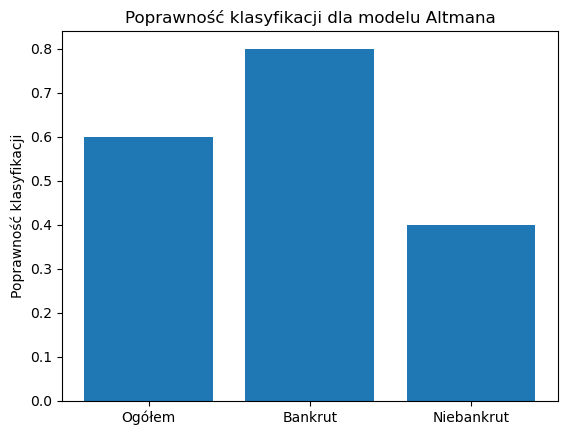

In [132]:
vars =  ['Attr3', 'Attr7', 'Attr12', 'Attr1','class']
vars_attr = vars[:-1]
data = pd.concat([random_b[vars], random_nb[vars]])
data.dropna(inplace=True)

data["Z"] = 1.03*data[vars[0]] + 3.07*data[vars[1]] + 0.66*data[vars[2]] + 0.4*data[vars[3]]
data["class_prediction"] = np.where(data["Z"] <= 0.862, "1", "0")

count_b = len(data[(data['class'] == "1") & (data['class_prediction'] == '1')])
count_nb = len(data[(data['class'] == "0") & (data['class_prediction'] == '0')])
count_all = len(data[((data['class'] == "1") & (data['class_prediction'] == '1')) | ((data['class'] == "0") & (data['class_prediction'] == '0'))])
print("Poprawność klasyfikacji ogółem: {:.2%}".format(count_all/len(data)))
print("Poprawność klasyfikacji bankrutów: {:.2%}".format(count_b/len(data[data['class'] == "1"])))
print("Poprawność klasyfikacji niebankrutów: {:.2%}".format(count_nb/len(data[data['class'] == "0"])))

fig, ax = plt.subplots()
ax.bar(["Ogółem", "Bankrut", "Niebankrut"], [count_all/len(data), count_b/len(data[data['class'] == "1"]), count_nb/len(data[data['class'] == "0"])])
ax.set_ylabel('Poprawność klasyfikacji')
ax.set_title('Poprawność klasyfikacji dla modelu Altmana')
plt.show()

#### Model B. Prusaka
- $X_1 \text{ (rentowność operacyjna aktywów)}= \frac{\text{zyski operacyjne}}{\text{aktywa ogółem}}$ - $X_{22}$ w naszym zbiorze danych

- $X_2 \text{ (relacja kosztów operacyjnych do zobowiązań)}= \frac{\text{koszty operacyjne}}{\text{zobowiązania ogółem}}$ - $X_{34}$ w naszym zbiorze danych
- $X_3 \text{ (płynność bieżąca)}= \frac{\text{aktywa obrotowe}}{\text{zobowiązania krótkoreminowe}}$ - $X_{4}$ w naszym zbiorze danych
- $X_4 \text{ (rentowność operacyjna sprzedaży)}= \frac{\text{zyski z działalności operacyjnej}}{\text{przychody netto ze sprzedaży}}$ - $X_{42}$ w naszym zbiorze danych

Model ma postać: $Z=6.5245 X_1 + 0.148 X_2 + 0.4061 X_3 + 2.1754 X_4 - 1.5685$

Poprawność klasyfikacji ogółem: 64.94%
Poprawność klasyfikacji bankrutów: 76.19%
Poprawność klasyfikacji niebankrutów: 51.43%


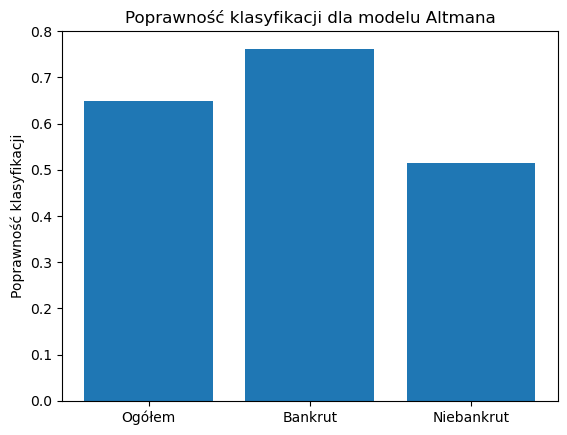

In [133]:
vars =  ['Attr22', 'Attr34', 'Attr4', 'Attr42','class']
vars_attr = vars[:-1]
data = pd.concat([random_b[vars], random_nb[vars]])
data.dropna(inplace=True)

data["Z"] = 6.5245*data[vars[0]] + 0.148*data[vars[1]] + 0.4061*data[vars[2]] + 2.1754*data[vars[3]] - 1.5685
data["class_prediction"] = np.where(data["Z"] <= -0.13, "1", np.where(data["Z"] > 0.65, "0", "2"))
data = data[data["class_prediction"] != "2"]

count_b = len(data[(data['class'] == "1") & (data['class_prediction'] == '1')])
count_nb = len(data[(data['class'] == "0") & (data['class_prediction'] == '0')])
count_all = len(data[((data['class'] == "1") & (data['class_prediction'] == '1')) | ((data['class'] == "0") & (data['class_prediction'] == '0'))])
print("Poprawność klasyfikacji ogółem: {:.2%}".format(count_all/len(data)))
print("Poprawność klasyfikacji bankrutów: {:.2%}".format(count_b/len(data[data['class'] == "1"])))
print("Poprawność klasyfikacji niebankrutów: {:.2%}".format(count_nb/len(data[data['class'] == "0"])))

fig, ax = plt.subplots()
ax.bar(["Ogółem", "Bankrut", "Niebankrut"], [count_all/len(data), count_b/len(data[data['class'] == "1"]), count_nb/len(data[data['class'] == "0"])])
ax.set_ylabel('Poprawność klasyfikacji')
ax.set_title('Poprawność klasyfikacji dla modelu Altmana')
plt.show()

W większości przypadków można zauważyć, że modele lepiej dopasowują bankrutów, natomiast skuteczność co do dopasowywania firm, które nie zbankrutowały jest niższa.